# Preparar Dataset y DataLoader

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


En primer lugar debe crearse una clase heredada de Dataset la cual permitirá obtener los datos que serán suministrados al modelo.


Esta clase tiene tres funciones importantes que deberán implementarse:
*   init() : procesos iniciales como leer un archivo csv, asignar transformaciones...
*   getitem() : devuelve dato y etiqueta dado un índice arbitrario
*   len() : devuelve el tamaño del dataset


In [3]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image  # es mejor trabajar con arreglos numpy o con PIL ?????
import glob
import os

class DatasetSegmentation(Dataset):

    def __init__(self, folder_path, transform):
        super(DatasetSegmentation, self).__init__()
        self.img_files = glob.glob( os.path.join(folder_path,'Images','*.png') )
        self.mask_files = glob.glob( os.path.join(folder_path,'Labels','*.png') )
        self.transform = transform

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]

            # data = Image.open(img_path).convert('RGB')  ## no se si es necesario que tenga 3 canales la imagen
            data = Image.open(img_path)
            # label = Image.open(mask_path).convert('RGB') 
            label = Image.open(mask_path)

            data = self.transform(data)
            label = self.transform(label)

            return data, label

    def __len__(self):
        return len(self.img_files)



A través de la función Compose del módulo transforms, se podrá crear un objeto que establece un conjunto de operaciones que serán aplicadas a los datos del dataset. Este objeto será pasado como argumento en el momento de instanciar el dataset.

In [4]:
from torchvision import transforms

size_inp_img = 128

trans = transforms.Compose([
    transforms.Resize(size_inp_img), # para acotar el tiempo de entrenamiento
    transforms.ToTensor()
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet (calcular esto valores antes)
])

Luego deberán instanciarse objetos tipo DataLoader. Esta clase permite cargar los datos de un Dataset para luego proveerlos al modelo. La ventaja que tiene es que los caraga en segundo plano para que estén listos ni bien sean necesarios. 

Además permite crear minibatch de datos (batch_size) como así también muestrearlos uniformemente luego de cada época (shuffle=True)


In [5]:
from torch.utils.data import DataLoader

# crear una instancia dataloader por cada dataset, con un batch_size dado y con shuffling activado

train_path = '/content/drive/My Drive/PFC/unet2D/datos-jsrt/Train'
validation_path = '/content/drive/My Drive/PFC/unet2D/datos-jsrt/Val'
test_path = '/content/drive/My Drive/PFC/unet2D/datos-jsrt/Test'

train_set = DatasetSegmentation(train_path, trans)
val_set = DatasetSegmentation(validation_path, trans)
test_set = DatasetSegmentation(test_path, trans)

image_datasets = { 'train': train_set, 'val': val_set, 'test' : test_set }

batch_size = 2 # especificar tamaño del batch

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size),
    'val': DataLoader(val_set, batch_size=batch_size),
    'test': DataLoader(test_set, batch_size=batch_size)
}


# Comprobar la salida del DataLoader

In [ ]:

def reverse_transform(inp):
    """ Esta función permite revertir las transformaciones aplicadas al inicio para poder mostrar cómo son originalmente """
    inp = transforms.ToPILImage()(inp)
    # inp = np.array(inp)
    # # print(inp)
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp/255 + mean
    # # print(inp)
    # inp = np.clip(inp, 0, 1)
    
    return inp

Pytorch requiere que las imágenes se almacenen en tensores con las siguientes dimensiones: B x C x H x W.

* B o N es el tamaño del batch o la cantidad de datos de dimensiones (C x H X W)
* C cantidad de canales de la imagen
* H altura de la imagen
* W ancho de la imagen

Cantidad de datos cargados:  87
shape:  torch.Size([2, 1, 128, 128]) torch.Size([2, 1, 128, 128])
dtype:  torch.float32 torch.float32


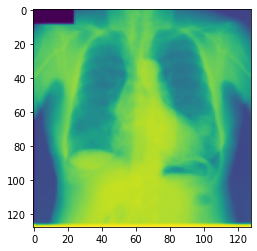

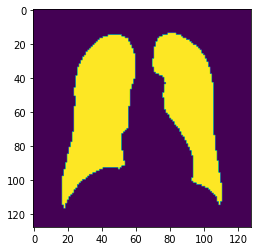

In [ ]:
import matplotlib.pyplot as plt

# Mostrar la cantidad de datos cargados, listos para procesar 
print('Cantidad de datos cargados: ',len(dataloaders['train']))

# Obtener un batch de los datos de entrenamiento
inputs, masks = next(iter(dataloaders['train']))

# N x C x H x W
print('shape: ',inputs.shape, masks.shape)
print('dtype: ',inputs.dtype, masks.dtype)

# print( transforms.ToPILImage()(inputs[0]) )
plt.figure()
# plt.imshow(reverse_transform(inputs[0]))
plt.imshow( reverse_transform(inputs[0]))

# print(reverse_transform(masks[0]))
plt.figure()
# plt.imshow(reverse_transform(masks[0])*255)
plt.imshow( transforms.ToPILImage()(masks[0]*255))

# Crear el modelo Unet

Este modelo se tomó de acá: https://github.com/ptrblck/pytorch_misc/blob/master/unet_demo.py#L81

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(BaseConv, self).__init__()

        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding, stride)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size, padding, stride)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels, kernel_size, padding, stride):
        super(UpConv, self).__init__()

        # self.conv_trans1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2) # original... converge mas lento
        self.conv_trans1 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, padding=0, stride=2)
        # ConvTranspose is a convolution and has trainable kernels while Upsample is a simple interpolation (bilinear, nearest etc.)
        # https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0

        self.conv_block = BaseConv(
            in_channels = in_channels + in_channels_skip,
            # in_channels = out_channels,  # original... converge mas lento
            out_channels = out_channels,
            kernel_size = kernel_size,
            padding = padding,
            stride = stride)

    def forward(self, x, x_skip):
        x = self.conv_trans1(x)
        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size, padding, stride):
        super(UNet, self).__init__()

        self.init_conv = BaseConv(in_channels, out_channels, kernel_size, padding, stride) # 2 conv

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size, padding, stride) # max pool y 2 (conv+relu)
        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size, padding, stride) # max pool y 2 (conv+relu)
        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size, padding, stride) # max pool y 2 (conv+relu)
        # el original hace un DownConv más

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels, kernel_size, padding, stride) # upconv, concat, 2 (conv+relu)
        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels, kernel_size, padding, stride) # upconv, concat, 2 (conv+relu)
        self.up1 = UpConv(2 * out_channels, out_channels, out_channels, kernel_size, padding, stride) # upconv, concat, 2 (conv+relu)

        self.out = nn.Conv2d(out_channels, n_class, kernel_size, padding, stride)

    def forward(self, x):
        # Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        # Decoder
        x_up = self.up3(x3, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)
        x_out = F.log_softmax(self.out(x_up), dim=1) # en otras arquitecturas unet no hace esto
        # softmax -> prob que suman 1 ... log_softmax -> reales negativos
        # identity activations in the final layer -> CrossEntropyLoss ... log_softmax activation -> NLLLoss
        # https://stats.stackexchange.com/questions/436766/cross-entropy-with-log-softmax-activation
        # https://discuss.pytorch.org/t/does-nllloss-handle-log-softmax-and-softmax-in-the-same-way/8835/6
        # https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d 
  
        return x_out


# Resumen del modelo

Mostrar un resumen del modelo a partir de una entrada dada. El mismo especifica cada una de las capas del modelo, con la forma del tensor de salida y la cantidad de parámetros. Por último se muestra el total de parámetros, cuántos son entrenables y tamaño que ocuparán en memoria.

In [ ]:
nb_classes = 2  # se cuenta desde la clase 0 a la 9
# x = torch.randn(1, 3, 96, 96)
# y = torch.randint(0, nb_classes, (1, 96, 96))

model = UNet(in_channels = 1,
            #  in_channels = 3,
             out_channels = 64,
            #  n_class = 10,
             n_class = nb_classes,
             kernel_size = 3,
             padding = 1,
             stride = 1 )
model = model.cuda()

loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
from torchsummary import summary
summary(model, input_size=(1, size_inp_img, size_inp_img))

# Definir la función de entrenamiento

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20): 

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    for epoch in range(epochs): 

        training_loss = 0.0         
        valid_loss = 0.0 
        epoch_samples = 0

        model.train()  # activa dropout (en este caso no hay)
        for inputs, target in train_loader: 
            target = target.squeeze(1) # analizar.. pero es xq la dimension channel no interesa

            inputs = inputs.to(device) 
            target = target.to(device) 

            # print('shape: ',inputs.shape, target.shape)
            # print('dtype: ',inputs.dtype, target.dtype)

            output = model(inputs) 
            loss = loss_fn(output, target.long())  # .type(torch.LongTensor) se agregó xq daba problema, analizar

            # gradients are accumulated on top of each other every time we call backward unless we zero out the gradients explicitly
            optimizer.zero_grad() # zeroes the grad attribute of all the parameters passed to the optimizer construction.
            loss.backward() # calcula los gradientes respecto de los parametros 
            optimizer.step() # pasada hacia adelante actualizando los parametros  

            # statistics
            training_loss += loss.data.item() # extracts the loss’s value as a Python float
            epoch_samples += inputs.size(0) # batch size
            print('training_loss: ',training_loss)
            print('epoch_samples: ',epoch_samples)

        training_loss /= epoch_samples

        epoch_samples = 0

        model.eval()  # dropout is bypassed or, equivalently, assigned a probability  equal  to  zero.
        num_correct = 0 
        num_examples = 0 
        for inputs, target in val_loader: 

            inputs = inputs.to(device) 
            target = target.to(device) 
            target = target.squeeze(1) # analizar.. pero es xq la dimension channel no interesa

            output = model(inputs) 
            loss = loss_fn(output, target.long()) 

            # statistics
            valid_loss += loss.data.item() 
            epoch_samples += inputs.size(0) # batch size

        valid_loss /= epoch_samples
 
        print('Epoch: {},  Training Loss: {:.3f},  Validation Loss: {:.3f}' \
              .format( epoch, training_loss, valid_loss) )

# Entrenar y validar

In [ ]:
train(model, optimizer, loss_fn, dataloaders['train'], dataloaders['val'], epochs=10)